In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from itertools import chain
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm
%matplotlib inline

In [2]:
def stoch_round(x):
    if np.random.rand() > x - int(x):
        return int(x)
    else:
        return int(x)+1

In [3]:
p_common = {"b2":0, 'd1':1, 'd2':1, 'K1':1, 'K2':1, 'mu':0.1, 'V':100, 's':10, 'mut':0.2, 'sigma': 0.1}
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}
p_strong = {"a1": 1, "b1": 1, "a2":2, **p_common}
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}

In [4]:
def compat(a, delta_u, s): # compatibilités de quelqu'un de trait a avec quelqu'un de différence delta_u
    a = a * 2 - 1 # on met dans [-1, 1]
    if a >= 0:
        return np.exp(-s*a*delta_u*delta_u) # voir si on met un facteur devant le a
    else:
        return (np.exp(s*a*(delta_u+1)**2) + np.exp(s*a*(delta_u-1)**2))/2

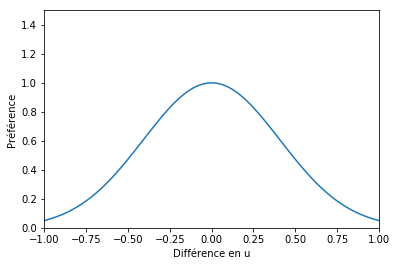

In [30]:
X = np.linspace(-1, 1, 1000)
Y = [compat(1, x, 3) for x in X]
plt.plot(X, Y)
plt.xlim(-1, 1)
plt.ylim(0, 1.5)
plt.ylabel('Préférence')
plt.xlabel('Différence en u')

In [5]:
def get_birth_rates(state, a1, a2, b1, b2, d1, d2, K1, K2, V, **reste):
    trait_step = state.shape[0]
    u_vals = np.linspace(0, 1, trait_step) # Liste des valeurs du trait u.
    N_per_u = np.sum(state, axis=1) / V # Nombre d'individus avec chaque valeur de u (pour calculer F1 et F2).
    
    A1_per_u = a1 + b1*u_vals # Valeur de A1 pour chaque valeur de u.    
    F1 = (d1 * K1) / (d1 * K1 + np.dot(u_vals, np.multiply(N_per_u, A1_per_u)))

    A2_per_u = a2 + b2*u_vals # Valeur de A2 pour chaque valeur de u.
    F2 = (d2 * K2) / (d2 * K2 + np.dot(1 - u_vals, np.multiply(N_per_u, A2_per_u)))
    
    beta_per_u = np.multiply(u_vals, A1_per_u) * F1 + np.multiply(1-u_vals, A2_per_u) * F2

    return beta_per_u

In [6]:
def stochastic_simul(Tmax, nb_steps, state, birth_rates, **params):
    """ Simulation stochastique avec l'algorithme de Gillespie.
    
    Paramètres :
        Tmax : temps final de la simulation.
        nb_steps : nombre d'étapes.
        state : np.ndarray de forme (trait_step, trait_step) représentant le nombre d'individus
                pour chaque couple (u, a) (u ligne, a colonne)
        get_birth_rates : fonction retournant le birth rate pour chaque u en fonction de l'état
        mu : taux de mortalité (indépendant des traits)
        
    """
    
    trait_step = state.shape[0] # combien de valeurs du trait on utilise
    dt = Tmax/nb_steps
    
    u_vals = np.linspace(0, 1, trait_step) # Liste des valeurs du trait u.
    a_vals = np.linspace(0, 1, trait_step) # Liste des valeurs du trait a.

    trajectory = np.zeros((nb_steps, trait_step, trait_step), dtype=int) # On sauvegarde l'état initial.
    
    for t in range(nb_steps):
        if t % 100 == 0:
            print('Étape {}, {:.1%}'.format(t, t/nb_steps))
            
#        if t % 500 == 0:
#            plt.imshow(np.sum(trajectory, axis = 2).transpose(), aspect='auto') # on somme sur a pour avoir (u, t)
#            plt.show()
            
        # on calcule tous les taux
        birth_rate_per_u = birth_rates(state)
        
        new_state = np.zeros((trait_step, trait_step))
        
        for u_i in range(trait_step):
            for a_i in range(trait_step):
                if state[u_i][a_i] > 0:
                    nb_repros = np.random.poisson(state[u_i][a_i]*birth_rate_per_u[u_i]*dt)
                    nb_morts = np.random.poisson(state[u_i][a_i]*params["mu"]*dt)
                    
                    for i in range(nb_repros):
                        # on trouve le nouveau partenaire avec proba N(u_i, a_i) * beta(u_i, a_i)
                        probas = (state.transpose() * birth_rate_per_u).transpose()
                        masse_totale = np.sum(probas)
                        
                        # u_part et a_part : traits du partenaire sélectionné
                        cases_non_vides = [(u, a) for u in range(trait_step) for a in range(trait_step)
                                           if probas[u, a] > 0]
                        trouve = False
                        u_part = -1
                        a_part = -1
                        while not trouve:
                            r = np.random.random()
                            pos = np.random.randint(0, len(cases_non_vides))
                            u_part, a_part = cases_non_vides[pos]
                            if r*masse_totale < probas[u_part][a_part]:
                                trouve = True
                        
                        delta_u = u_vals[u_i] - u_vals[u_part]
                        proba_repro = compat(a_vals[a_i], delta_u, params["s"]) * compat(a_vals[a_part], delta_u, params["s"])
                        
                        if np.random.binomial(1, proba_repro):
                            # héritage des traits des parents
                            u_min = min(u_i, u_part)
                            u_max = max(u_i, u_part)
                            nouv_u = np.random.randint(u_min, u_max+1) # au lieu de stoch_round((u_i + u_part)/2)
                            a_min = min(a_i, a_part)
                            a_max = max(a_i, a_part)
                            nouv_a = np.random.randint(a_min, a_max+1)
                            
                            if np.random.random() < params["mut"]:
                                mut_u, mut_a = np.random.normal([0, 0], [params["sigma"], params["sigma"]])
                                nouv_u = stoch_round(nouv_u + mut_u * trait_step)
                                nouv_a = stoch_round(nouv_a + mut_a * trait_step)

                            nouv_u = min(max(nouv_u, 0), trait_step-1)
                            nouv_a = min(max(nouv_a, 0), trait_step-1)

                            new_state[nouv_u][nouv_a] += 1
                        
                    new_state[u_i][a_i] = max(state[u_i][a_i] + new_state[u_i][a_i] - nb_morts, 0)
                        
        trajectory[t, :, :] = state[:, :]
        state = new_state
        
    return trajectory

In [7]:
trait_step = 40
state = np.zeros((trait_step, trait_step))
state[0, trait_step-1] = 100
state[trait_step-1, trait_step-1] = 100
#state[0, (trait_step-1)//2] = 200

In [8]:
traj = stochastic_simul(1000, 10000, state, partial(get_birth_rates, **p_strong), **p_strong)

Étape 0, 0.0%
Étape 100, 1.0%
Étape 200, 2.0%
Étape 300, 3.0%
Étape 400, 4.0%
Étape 500, 5.0%
Étape 600, 6.0%
Étape 700, 7.0%
Étape 800, 8.0%
Étape 900, 9.0%
Étape 1000, 10.0%
Étape 1100, 11.0%
Étape 1200, 12.0%
Étape 1300, 13.0%
Étape 1400, 14.0%
Étape 1500, 15.0%
Étape 1600, 16.0%
Étape 1700, 17.0%
Étape 1800, 18.0%
Étape 1900, 19.0%
Étape 2000, 20.0%
Étape 2100, 21.0%
Étape 2200, 22.0%
Étape 2300, 23.0%
Étape 2400, 24.0%
Étape 2500, 25.0%
Étape 2600, 26.0%
Étape 2700, 27.0%
Étape 2800, 28.0%
Étape 2900, 29.0%
Étape 3000, 30.0%
Étape 3100, 31.0%
Étape 3200, 32.0%
Étape 3300, 33.0%
Étape 3400, 34.0%
Étape 3500, 35.0%
Étape 3600, 36.0%
Étape 3700, 37.0%
Étape 3800, 38.0%
Étape 3900, 39.0%
Étape 4000, 40.0%
Étape 4100, 41.0%
Étape 4200, 42.0%
Étape 4300, 43.0%
Étape 4400, 44.0%
Étape 4500, 45.0%
Étape 4600, 46.0%
Étape 4700, 47.0%
Étape 4800, 48.0%
Étape 4900, 49.0%
Étape 5000, 50.0%
Étape 5100, 51.0%
Étape 5200, 52.0%
Étape 5300, 53.0%
Étape 5400, 54.0%
Étape 5500, 55.0%
Étape 5600, 56

In [9]:
def plot_trait(trait, nom):
    trait = np.flipud(trait) # on remet le 0 en bas
    nb_gens = trait.shape[1]
    plt.figure(figsize=(9, 6))
    plt.imshow(trait, extent=[0, nb_gens, 0, 1], aspect='auto')
    plt.xlabel('Génération')
    plt.ylabel('Trait ' + nom)

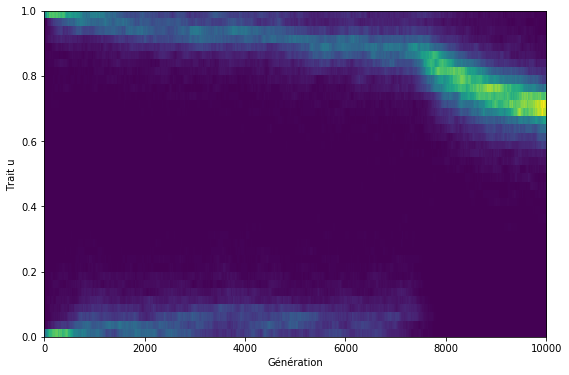

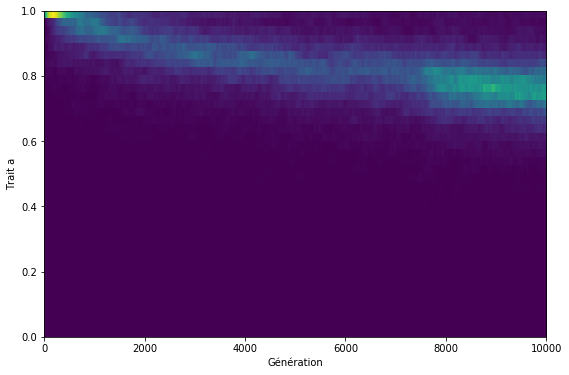

In [10]:
plot_trait(np.sum(traj, axis = 2).transpose(), 'u') # on somme sur a pour avoir (u, t)
plot_trait(np.sum(traj, axis = 1).transpose(), "a") # on somme sur u pour avoir (a, t)